In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# Import standard modules
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.set_cmap('jet')
import os
import pickle

<Figure size 432x288 with 0 Axes>

In [5]:
# Import torch modules
import torch
from torch import FloatTensor, cat, from_numpy
from torch.autograd import Variable
from torchsummary import summary

In [6]:
import sys
sys.path.append('../src/')

In [7]:
# Import transform net
from model_transform_net import ModelTransformNet

In [8]:
# Import utils function
from utils import dot_dict, load_model, gram_matrix

#### 1. Specify options

In [9]:
device = 'cuda'

In [10]:
data_dir = './data/'

In [24]:
args = {}
args['m_pca'] = os.path.join(data_dir, 'm_pca_test200_case1.h5')         # New PCA models
args['m_petrel'] = os.path.join(data_dir, 'm_petrel_train3000_case1.h5')         # New PCA models
args['save_model'] = './weights/fw_weights_case1_sw100.0_rw500.0_hw10.0_9ep.pth' 
args = dot_dict(args)

#### 2. Load data

In [25]:
# Load m_pca
m_pca = load_model(args.m_pca).astype(np.float32)
m_pca = m_pca.transpose((0, -1, 1,2,3))
m_pca.shape

(200, 1, 40, 60, 60)

In [26]:
# Normalize data
max_, min_ = 1., 0.
m_pca = (m_pca - min_) / (max_ - min_) * 255.

#### 3. Construct Transform Net

In [27]:
trans_net = ModelTransformNet()
trans_net = trans_net.to(device)
summary(trans_net, input_size=(1, 40, 60, 60), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      CirularPad3d-1        [-1, 1, 42, 68, 68]               0
            Conv3d-2       [-1, 32, 40, 60, 60]           7,808
         ConvLayer-3       [-1, 32, 40, 60, 60]               0
       BatchNorm3d-4       [-1, 32, 40, 60, 60]              64
              ReLU-5       [-1, 32, 40, 60, 60]               0
      CirularPad3d-6       [-1, 32, 42, 62, 62]               0
            Conv3d-7       [-1, 64, 20, 30, 30]          55,360
         ConvLayer-8       [-1, 64, 20, 30, 30]               0
       BatchNorm3d-9       [-1, 64, 20, 30, 30]             128
             ReLU-10       [-1, 64, 20, 30, 30]               0
     CirularPad3d-11       [-1, 64, 22, 32, 32]               0
           Conv3d-12      [-1, 128, 20, 15, 15]         221,312
        ConvLayer-13      [-1, 128, 20, 15, 15]               0
      BatchNorm3d-14      [-1, 128, 20,

#### 4. Load Weights

In [28]:
trans_net.load_state_dict(torch.load(args.save_model, map_location=torch.device(device)))
trans_net.eval()
print('')

#### 5. Evaluate on Test PCA Models

In [29]:
num_model = m_pca.shape[0]

In [30]:
batch_size = 4
num_batch = num_model // batch_size
fw_m_pca = np.zeros_like(m_pca)

In [31]:
for ib in range(num_batch):
    ind0 = ib * batch_size
    ind1 = ind0 + batch_size
    data = m_pca[ind0:ind1, ...]
    fw_m_pca[ind0:ind1, ...] = trans_net(Variable(torch.from_numpy(data).float()).to(device)).data.cpu().numpy()

#### 6. Histogram Transform to Match Sand Fraction

In [32]:
# Load m_petrel
m_petrel = load_model(args.m_petrel).astype(np.float32)
m_petrel = m_petrel.transpose((0, -1, 1,2,3))
m_petrel.shape

(3000, 1, 40, 60, 60)

In [33]:
bins = 200
hist, bins_target = np.histogram(m_petrel.flatten(), bins)
cdf_target = hist.cumsum()
cdf_target = cdf_target / cdf_target.max()
cdf_target = np.concatenate(([0], cdf_target))

In [34]:
def hist_trans(data, cdf_target, bins_target, bins):
    hist, bins = np.histogram(data.flatten(), bins)
    cdf = hist.cumsum()
    cdf = cdf / cdf.max()
    cdf = np.concatenate(([0], cdf))
    # Histogram transformation
    cdf_values = np.interp(data.flatten(), bins, cdf)
    data_ht = np.interp(cdf_values, cdf_target, bins_target)
    data_ht = data_ht.reshape(data.shape)
    return data_ht

In [35]:
batch_size = 20
num_batch = num_model // batch_size
m_cnnpca = np.zeros_like(fw_m_pca)
for ib in range(num_batch):
    ind0 = ib * batch_size
    ind1 = ind0 + batch_size
    data = fw_m_pca[ind0:ind1, ...]
    m_cnnpca[ind0:ind1, ...] = hist_trans(data, cdf_target, bins_target, bins)

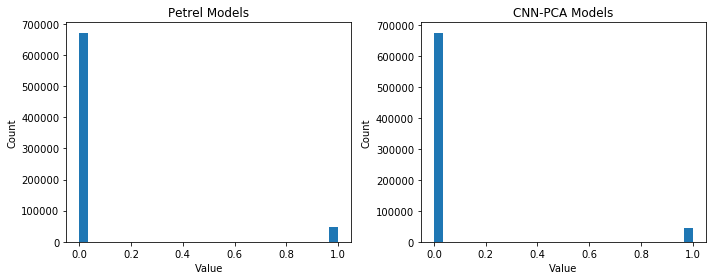

In [36]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(m_petrel[:5, ...].flatten(),30)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Petrel Models")
plt.subplot(1,2,2)
plt.hist(m_cnnpca[:5, ...].flatten(),30)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("CNN-PCA Models")
plt.tight_layout()
plt.show()

In [37]:
# Define well locations
well_loc = {}
well_loc['I1'] = (15, 2)
well_loc['I2'] = (45, 3)
well_loc['P1'] = (13, 57)
well_loc['P2'] = (43, 58)

In [38]:
def plot_wells(c='k'):
    for wn in well_loc:
        wloc = well_loc[wn]
        plt.plot(wloc[0]-1, wloc[1]-1, c+'.')
        plt.text(wloc[0]+1, wloc[1]+1, wn, color=c)

Model 1


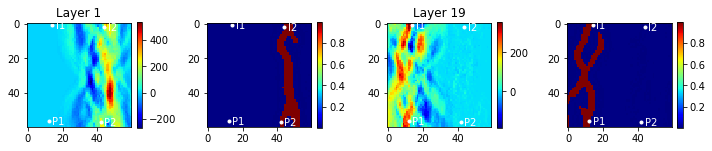

Model 2


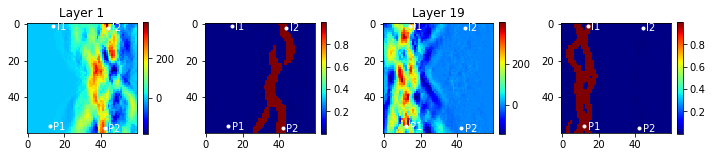

Model 3


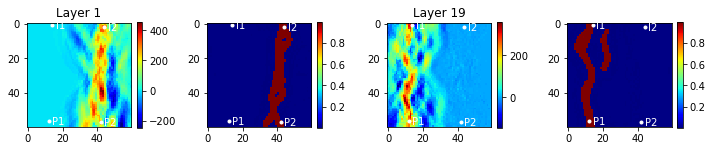

Model 4


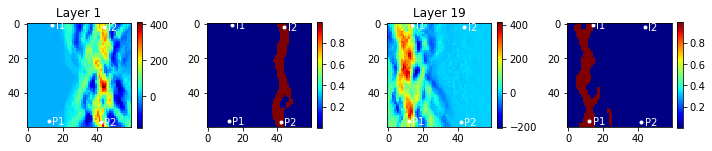

Model 5


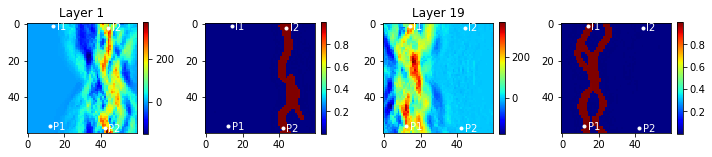

In [39]:
layers = [0, 18]
nz = len(layers)
for k in range(5):
    print('Model %d' % (k+1))
    plt.figure(figsize=(10,5))
    for ind, z in enumerate(layers):
        plt.subplot(1,4,2*ind+1)
        plt.imshow(m_pca[k, 0, z, :, :])
        plot_wells('w')
        plt.colorbar(fraction=0.046)
        plt.title('Layer %d' % (z+1))        
        plt.subplot(1,4,2*ind+nz)
        plt.imshow(m_cnnpca[k, 0, z, :, :])
        plot_wells('w')
        plt.colorbar(fraction=0.046)
    plt.tight_layout()
    plt.show()

In [40]:
# Save CNN-PCA Models
fid = h5py.File(os.path.join(data_dir,'m_cnnpca_test200_case1.h5'), 'w')
fid.create_dataset('data', data=m_cnnpca)
fid.close()

In [41]:
exit()